# **The Battle of the Neighborhoods**

## This report consists of following sections -

 - Introduction: Business Problem
 - Data
 - Methodology
 - Analysis
 - Results and Discussion
 - Conclusion

## Introduction

The objective of this exercise is to 
- find the safest borough in London based on number of crimes reported
- Find the 10 most common venues in each of those (safe) neighborhood
- Cluster the neighborhoods using k-mean clustering.

This report will benefit people who are looking to relocate to London. Safety of the place is one of the major contributing factor in decision making and that is decided based on crimes reported in the area. 


## Data 
As per problem description factors influencing our decision are:

- The total number of crimes reported in each of the borough.
- The most common venues in each of the neighborhood in the safest borough selected.

Following data sources will be needed to extract/generate the required information:

1. Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016: A dataset consisting of the crime statistics of each borough in London obtained from Kaggle

2. Scraping additional information of the different Boroughs in London from a Wikipedia page.: More information regarding the boroughs of London is scraped using the Beautifulsoup library

3. Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.: Co-ordinate of neighborhood will be obtained using Google Maps API geocoding

## Preprocessing
**London Crime Data**

- lsoa_code: code for Lower Super Output Area in Greater London.
- borough: Common name for London borough.
- major_category: High level categorization of crime
- minor_category: Low level categorization of crime within major category.
- value: monthly reported count of categorical crime in given borough
- year: Year of reported counts, 2008-2016
- month: Month of reported counts, 1-12

Data set URL: https://www.kaggle.com/jboysen/london-crime

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
# !conda install -c conda-forge BeautifulSoup4 --yes
from bs4 import BeautifulSoup # library for web scrapping  

!conda install -c conda-forge geocoder --yes
import geocoder

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

In [6]:
#Foursquare credentials
CLIENT_ID = '5OW4ZZCPNEL1MZXXRVUPKNGE0HOGJH1CHYR5OYZO3O5WVOIR' # your Foursquare ID
CLIENT_SECRET = 'GRMRKFICOSN1SUKBPYBKBKVYPIFUAFGRX1Q0WTW4FRBLYPRH' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5OW4ZZCPNEL1MZXXRVUPKNGE0HOGJH1CHYR5OYZO3O5WVOIR
CLIENT_SECRET:GRMRKFICOSN1SUKBPYBKBKVYPIFUAFGRX1Q0WTW4FRBLYPRH


In [7]:
# Read in the data 
df = pd.read_csv("london_crime_by_lsoa.csv")

In [8]:
# View sample data set
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [9]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [10]:
# Shape of the data frame
df.shape

(392042, 7)

In [11]:
# View sample data set
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


**Replacing column names**

In [12]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [13]:
# information of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
LSOA_Code         392042 non-null object
Borough           392042 non-null object
Major_Category    392042 non-null object
Minor_Category    392042 non-null object
No_of_Crimes      392042 non-null int64
Year              392042 non-null int64
Month             392042 non-null int64
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


In [14]:
# Total number of crimes in each Borough
df['Borough'].value_counts()

Lambeth                   17605
Southwark                 16560
Croydon                   16254
Newham                    15622
Ealing                    15284
Tower Hamlets             15219
Brent                     14980
Barnet                    14668
Hackney                   14392
Lewisham                  14235
Haringey                  14202
Enfield                   13658
Wandsworth                13498
Westminster               13383
Islington                 13116
Greenwich                 12750
Camden                    12632
Hillingdon                12417
Hounslow                  12316
Waltham Forest            12121
Bromley                   11980
Redbridge                 11490
Hammersmith and Fulham    10281
Barking and Dagenham       9784
Havering                   9699
Kensington and Chelsea     9653
Harrow                     8257
Bexley                     8245
Merton                     8223
Richmond upon Thames       7199
Sutton                     6823
Kingston

In [15]:
# total crimes per major category
df['Major_Category'].value_counts()

Theft and Handling             129159
Violence Against the Person    123050
Criminal Damage                 48584
Burglary                        43020
Drugs                           21782
Robbery                         14889
Other Notifiable Offences       11558
Name: Major_Category, dtype: int64

In [16]:
# no. of crimes for each major category in each Borough

London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1287            1949   919   
Barnet                       3402            2183   906   
Bexley                       1123            1673   646   
Brent                        2631            2280  2096   
Bromley                      2214            2202   728   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       378     534               5607   
Barnet                                     499     464               9731   
Bexley                                     294     209               4392   
Brent                                      536     919               9026   
Bromley                                    417     369               7584   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        6067  
Barnet                                      7499  
Bexley                                      4503  
Brent                                       9205  
Bromley                                     6650

In [17]:
# Total crimes per Borough
London_crime.reset_index(inplace = True)
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(33)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham         1287            1949   919   
1                               Barnet         3402            2183   906   
2                               Bexley         1123            1673   646   
3                                Brent         2631            2280  2096   
4                              Bromley         2214            2202   728   
5                               Camden         2652            1935  1493   
6                       City of London            2               2    10   
7                              Croydon         2738            3219  1367   
8                               Ealing         2492            2562  1355   
9                              Enfield         2541            2136  1063   
10                           Greenwich         1780            2476   867   
11                             Hackney         2719            1981  1353   
12              Hammersmith and Fulham         1531            1408  1321   
13                            Haringey         2474            2233  1540   
14                              Harrow         1994            1212   473   
15                            Havering         1826            1804   718   
16                          Hillingdon         2229            2470  1042   
17                            Hounslow         1808            2213  1086   
18                           Islington         2051            1903  1777   
19              Kensington and Chelsea         1449            1051  1680   
20                Kingston upon Thames          879            1054   743   
21                             Lambeth         3087            2764  2738   
22                            Lewisham         2071            2351  1617   
23                              Merton         1419            1418   466   
24                              Newham         2115            2496  1684   
25                           Redbridge         1997            1650  1017   
26                Richmond upon Thames         1359            1148   320   
27                           Southwark         2946            2621  1838   
28                              Sutton         1233            1316   461   
29                       Tower Hamlets         2794            2357  1629   
30                      Waltham Forest         1873            1989  1042   
31                          Wandsworth         2351            1836   870   
32                         Westminster         3218            2179  2049   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    378     534               5607   
1                                    499     464               9731   
2                                    294     209               4392   
3                                    536     919               9026   
4                                    417     369               7584   
5                                    490     899              14088   
6                                      6       4                129   
7                                    718    1139               9229   
8                                    613     669              10040   
9                                    492     807               8037   
10                                   521     486               8010   
11                                   499    1030              11851   
12                                   474     397               8925   
13                                   551    1248              10554   
14                                   267     377               4537   
15                                   389     311               5919   
16                                  1305     420         

In [18]:
# Removing the multi index so that it will be easier to merge
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [19]:
# Renaming columns
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [20]:
London_crime.shape

(33, 9)

### Pullimg additional information of the different Boroughs in London from a Wikipedia page

In [21]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XhLUcgpAICkAAFX3W8AAAABD","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":931680068,"wgRevisionId":931680068,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories

In [22]:
# extracting the raw table
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a class="new" href="/w/index.php?title=Barking_Town_Hall&amp;actio

In [23]:
# Convertable table into dataframe
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [24]:

# Read in the second table 
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [25]:

# Appending data frames together

London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [26]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [27]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
Borough                     33 non-null object
Inner                       4 non-null object
Status                      5 non-null object
Local authority             33 non-null object
Political control           33 non-null object
Headquarters                33 non-null object
Area (sq mi)                33 non-null float64
Population (2013 est)[1]    33 non-null int64
Co-ordinates                33 non-null object
Nr. in map                  33 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ KB


In [28]:
# Removing unnecessary strings from data set
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [29]:
type(London_table)

pandas.core.frame.DataFrame

In [30]:
London_table.shape

(33, 10)

In [31]:
# Checking if Borough in both data sets match
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

***These 3 Boroughs don't match because of symobols present "[]"***

In [32]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


*These are the index of boroughs who did not match*

In [34]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

In [35]:
set(df.Borough) - set(London_table.Borough)

set()

*Now we are ready to combine both datasets together*

In [37]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,3402,2183,906,499,464,9731,7499,24684,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,2631,2280,2096,536,919,9026,9205,26693,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,2214,2202,728,417,369,7584,6650,20164,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,2652,1935,1493,490,899,14088,7626,29183,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,City of London,2,2,10,6,4,129,25,178,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1
7,Croydon,2738,3219,1367,718,1139,9229,10302,28712,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
8,Ealing,2492,2562,1355,613,669,10040,9396,27127,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
9,Enfield,2541,2136,1063,492,807,8037,7409,22485,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30


In [38]:
Ld_crime.shape

(33, 18)

In [39]:
set(df.Borough) - set(Ld_crime.Borough)

set()

In [40]:

# List of Column names of the data frame 
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [41]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,1287,1949,919,378,534,5607,6067,16741
1,Barnet,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3402,2183,906,499,464,9731,7499,24684
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12840
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2214,2202,728,417,369,7584,6650,20164


### Methodology
The methodology in this project consists of two parts:

- Exploratory Data Analysis: Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.
- Modelling: To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.

**Exploratory Data Analysis**

In [42]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2069.242424,1941.545455,1179.212121,479.060606,682.666667,8913.121212,7041.848485,22306.696970
std,737.448644,625.207070,586.406416,223.298698,441.425366,4620.565054,2513.601551,8828.228749
min,2.000000,2.000000,10.000000,6.000000,4.000000,129.000000,25.000000,178.000000
25%,1531.000000,1650.000000,743.000000,378.000000,377.000000,5919.000000,5936.000000,16903.000000
50%,2071.000000,1989.000000,1063.000000,490.000000,599.000000,8925.000000,7409.000000,22730.000000
75%,2631.000000,2351.000000,1617.000000,551.000000,936.000000,10789.000000,8832.000000,27174.000000
max,3402.000000,3219.000000,2738.000000,1305.000000,1822.000000,27520.000000,10834.000000,48330.000000


In [43]:

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.1


In [44]:

Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Ld_crime.columns)

True

In [45]:

Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3218,2179,2049,708,1822,27520,10834,48330
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,3087,2764,2738,635,1196,13155,10496,34071
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2946,2621,1838,494,1317,12946,9474,31636
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2115,2496,1684,713,1472,11964,9646,30090
29,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,2794,2357,1629,678,1234,10953,9608,29253


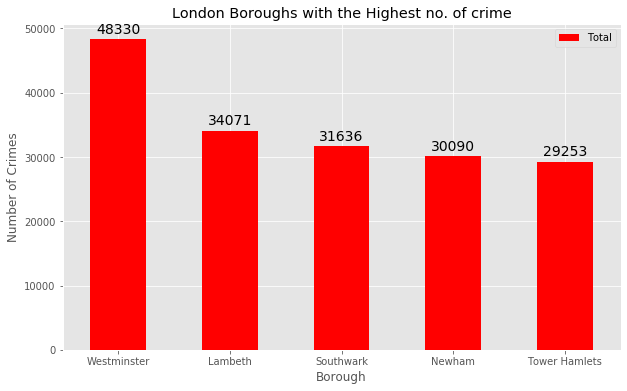

In [51]:
# Visualize the borough with high crimes
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0, color = "red")

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

In [47]:
# 5 boroughs with the highest number of crimes
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,2,2,10,6,4,129,25,178
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,879,1054,743,189,121,3803,3194,9983
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1233,1316,461,253,165,3516,3714,10658
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1359,1148,320,217,106,4769,3155,11074
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,1419,1418,466,249,283,4894,4026,12755


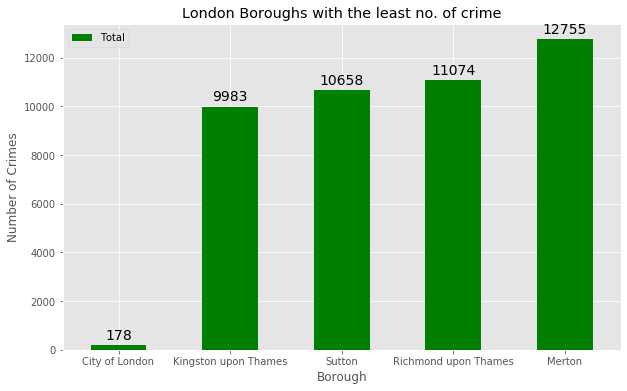

In [52]:
# boroughs with least number of crimes
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0, color = "green")

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

*City of London has the lowest no. of crimes recorded for the year 2016, Looking into the details of the borough:*

In [53]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,178,1.12,7000


*Apart from London the next borough with the least crime i.e. Kingston upon Thames*

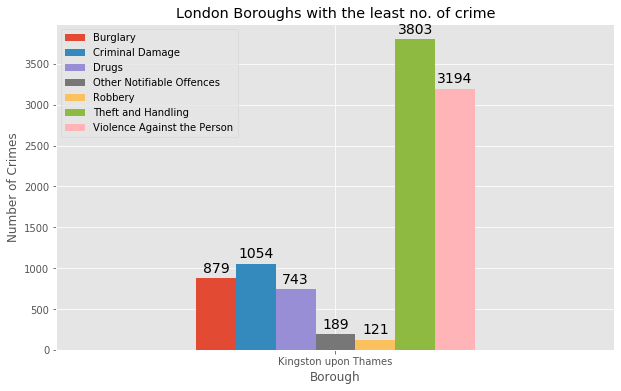

In [54]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

**We can conclude that Kingston upon Thames is the safest borough when compared to the other boroughs in London.**

***Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.***

*The list of Neighborhoods in the Royal Borough of Kingston upon Thames was found on a wikipedia page: https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames*

In [55]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


In [81]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address, timeout=10)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.305552805049262, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [82]:

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


**Get the co-ordinates of Berrylands, London, United Kingdom (The center neighborhood of Kingston upon Thames)**

In [83]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address, timeout=10)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


**Visualize the Neighborhood of Kingston upon Thames Borough**

In [84]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

## Modelling 
- Finding all the venues within a 500 meter radius of each neighborhood.
- Perform one hot ecoding on the venues data.
- Grouping the venues by the neighborhood and calculating their mean.
- Performing a K-means clustering (Defining K = 5)

**Create a function to extract the venues from each Neighborhood**

In [85]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [86]:

kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [87]:

print(kut_venues.shape)
kut_venues.head()

(169, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park
4,Canbury,51.417499,-0.305553,The Boater's Inn,51.418546,-0.305915,Pub


In [88]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,3,3,3,3,3,3
Canbury,14,14,14,14,14,14
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,8,8,8,8,8,8
Norbiton,27,27,27,27,27,27


In [89]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 69 uniques categories.


*There are 69 uniques categories.*

In [90]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,Breakfast Spot,Burger Joint,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,Breakfast Spot,Burger Joint,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.071429,0.0000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Hook,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Kingston Vale,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.2500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston upon Thames,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,0.0000,0.000000,0.066667,...,0.000000,0.0000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000
5,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.2500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,New Malden,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Norbiton,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.0000,0.037037,0.000000,...,0.000000,0.0000,0.037037,0.037037,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037
9,Old Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000


In [92]:
kut_grouped.shape

(13, 70)

In [93]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0  Gym / Fitness Center  0.33
1                  Park  0.33
2              Bus Stop  0.33
3        Hardware Store  0.00
4                 Hotel  0.00


----Canbury----
                  venue  freq
0                   Pub  0.29
1           Supermarket  0.07
2  Gym / Fitness Center  0.07
3     Fish & Chips Shop  0.07
4                  Park  0.07


----Hook----
               venue  freq
0             Bakery  0.25
1  Indian Restaurant  0.25
2  Fish & Chips Shop  0.25
3        Supermarket  0.25
4   Asian Restaurant  0.00


----Kingston Vale----
                venue  freq
0       Grocery Store  0.25
1        Soccer Field  0.25
2                 Bar  0.25
3  Italian Restaurant  0.25
4         Pizza Place  0.00


----Kingston upon Thames----
              venue  freq
0              Café  0.10
1       Coffee Shop  0.10
2               Pub  0.07
3      Burger Joint  0.07
4  Sushi Restaurant  0.07


----Malden Rushett----
                venue 

In [94]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [95]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Bus Stop,Gym / Fitness Center,Park,Wine Shop,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
1,Canbury,Pub,Park,Fish & Chips Shop,Supermarket,Spa,Shop & Service,Gym / Fitness Center,Plaza,Indian Restaurant,Hotel
2,Hook,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,Food,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
3,Kingston Vale,Grocery Store,Italian Restaurant,Bar,Soccer Field,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
4,Kingston upon Thames,Coffee Shop,Café,Burger Joint,Sushi Restaurant,Pub,Asian Restaurant,Cosmetics Shop,Electronics Store,Market,Mexican Restaurant


**Clustering similar neighborhoods together using k - means clustering**

In [96]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 2, 1, 2, 2, 3, 2, 2, 4])

In [97]:

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,0.0,Bus Stop,Gym / Fitness Center,Park,Wine Shop,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
1,Canbury,Kingston upon Thames,51.417499,-0.305553,2.0,Pub,Park,Fish & Chips Shop,Supermarket,Spa,Shop & Service,Gym / Fitness Center,Plaza,Indian Restaurant,Hotel
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,2.0,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,Food,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant


In [98]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
Neighborhood              15 non-null object
Borough                   15 non-null object
Latitude                  15 non-null float64
Longitude                 15 non-null float64
Cluster Labels            13 non-null float64
1st Most Common Venue     13 non-null object
2nd Most Common Venue     13 non-null object
3rd Most Common Venue     13 non-null object
4th Most Common Venue     13 non-null object
5th Most Common Venue     13 non-null object
6th Most Common Venue     13 non-null object
7th Most Common Venue     13 non-null object
8th Most Common Venue     13 non-null object
9th Most Common Venue     13 non-null object
10th Most Common Venue    13 non-null object
dtypes: float64(3), object(12)
memory usage: 1.9+ KB


In [99]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [100]:

kut_merged.shape

(13, 15)

In [101]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [102]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 14
Data columns (total 15 columns):
Neighborhood              13 non-null object
Borough                   13 non-null object
Latitude                  13 non-null float64
Longitude                 13 non-null float64
Cluster Labels            13 non-null int32
1st Most Common Venue     13 non-null object
2nd Most Common Venue     13 non-null object
3rd Most Common Venue     13 non-null object
4th Most Common Venue     13 non-null object
5th Most Common Venue     13 non-null object
6th Most Common Venue     13 non-null object
7th Most Common Venue     13 non-null object
8th Most Common Venue     13 non-null object
9th Most Common Venue     13 non-null object
10th Most Common Venue    13 non-null object
dtypes: float64(2), int32(1), object(12)
memory usage: 1.6+ KB


**Visualize the clusters**

In [103]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Each cluster is color coded for the ease of presentation, we can see that majority of the neighborhood falls in the red cluster which is the first cluster. Three neighborhoods have their own cluster (Blue, Purple and Yellow), these are clusters two three and five. The green cluster consists of two neighborhoods which is the 4th cluster.

### Analysis 
Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

Examine the first cluster

In [104]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,0,Bus Stop,Gym / Fitness Center,Park,Wine Shop,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


This cluster has one neighborhood which consists of Venues such as Bus stop, Park, Dry Cleaner, Fast Food resturents

second cluster

In [105]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.43185,-0.258138,1,Grocery Store,Italian Restaurant,Bar,Soccer Field,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


This cluster has one neighborhood which consists of Venues such as Grocery Store, Italian Restaurant, Bar,Soccer Field, Discount StorBus stop, Park, Dry Cleaner, Fast Food resturents

*Third Cluster*

In [107]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,2,Pub,Park,Fish & Chips Shop,Supermarket,Spa,Shop & Service,Gym / Fitness Center,Plaza,Indian Restaurant,Hotel
4,Hook,Kingston upon Thames,51.367898,-0.307145,2,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,Food,Discount Store,Dry Cleaner,Electronics Store,Farmers Market,Fast Food Restaurant
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,2,Coffee Shop,Café,Burger Joint,Sushi Restaurant,Pub,Asian Restaurant,Cosmetics Shop,Electronics Store,Market,Mexican Restaurant
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,2,Convenience Store,Garden Center,Pub,Restaurant,Farmers Market,Deli / Bodega,Department Store,Discount Store,Dry Cleaner,Electronics Store
9,New Malden,Kingston upon Thames,51.405335,-0.263407,2,Gastropub,Indian Restaurant,Bar,Sushi Restaurant,Supermarket,Gym,Korean Restaurant,Chinese Restaurant,Dry Cleaner,Electronics Store
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,2,Indian Restaurant,Food,Italian Restaurant,Pub,Wine Shop,Platform,Athletics & Sports,Breakfast Spot,Coffee Shop,Dry Cleaner
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,2,Indian Restaurant,Café,Coffee Shop,Pub,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Restaurant,Hotel,Wine Shop
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,2,Coffee Shop,Pub,Grocery Store,Gastropub,Train Station,Farmers Market,Gym / Fitness Center,Hotel,Italian Restaurant,Deli / Bodega
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,2,Grocery Store,Pharmacy,Sandwich Place,Furniture / Home Store,Train Station,Hotel,Discount Store,Coffee Shop,Bus Stop,Restaurant


*The cluster one is the biggest cluster with 9 of the 15 neighborhoods in the borough Kingston upon Thames. Upon closely examining these neighborhoods we can see that the most common venues in these neighborhoods are Restaurants, Pubs, Cafe, Supermarkets, and stores.*

*Fourth Cluster*

In [108]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,3,Gym,Construction & Landscaping,Park,Soccer Field,Wine Shop,Fast Food Restaurant,Discount Store,Dry Cleaner,Electronics Store,Farmers Market


This cluster has one neighborhood which consists of Venues such as Soccer Field, Wine Shop, Fast Food resturents, Electronics Store

*Fifth Cluster*

In [110]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Old Malden,Kingston upon Thames,51.382484,-0.25909,4,Grocery Store,Construction & Landscaping,Food,Train Station,Bar,Discount Store,Gift Shop,German Restaurant,Gastropub,Garden Center


*The Fifth cluster has one neighborhood which consists of Venues such as Train stations, Restaurants, and Furniture shops.*

### Results
The aim of this project is to help people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable. For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family.

### Conclusion 
This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget